In [12]:
from cmtj import *
import matplotlib.pyplot as plt
import numpy as np

from cmtj.utils.parallel import distribute
from cmtj.utils import OetoAm, FieldScan, compute_sd
from scipy.fft import fft, fftfreq

from cmtj import SolverMode
import math
from collections import defaultdict
from tqdm import tqdm

# GMR system
For the GMR system we will take a look at the Spin-Diode maps as well as on the PIMM maps in function of variable IEC.

## Voltage Spin-Diode

In [16]:
loops0 = {}
loops90 = {}

loop_Hrange = np.linspace(-500 * OetoAm, 500 * OetoAm, 100)
loop_Hrange = np.concatenate((loop_Hrange, loop_Hrange[:-1][::-1]))
labels = ('2.37', '2.14', '1.90')
HJs = (30, 10, -40)
Js = [HJ * OetoAm * 6e-9 * 1.65 for HJ in HJs]
# approximate demagnetisation tensor
demag = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 1)]
surf = 15e-9 * 15e-9 * np.pi
for angle in (90, 0):
    for th, J in zip(labels, tqdm(Js)):
        Ku = 0.8e3
        alpha = 0.024
        l1 = Layer(
            "free",
            mag=CVector(1, 0.1, 0.1),
            anis=CVector(1, 0., 0.),  # direction of the anisotropy
            Ms=1.03,
            thickness=float(th) * 1e-9,
            cellSurface=surf,
            demagTensor=demag,
            damping=alpha)

        l2 = Layer(
            "bottom",
            mag=CVector(1, 0.1, 0.1),
            anis=CVector(1, 0, 0),  # direction of the anisotropy
            Ms=1.65,
            thickness=6e-9,
            cellSurface=surf,
            demagTensor=demag,
            damping=alpha)

        j1 = Junction([l1, l2], 160, 200)
        j1.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(Ku))
        j1.setLayerAnisotropyDriver("bottom",
                                    ScalarDriver.getConstantDriver(1e12))
        j1.setIECDriver("free", "bottom", ScalarDriver.getConstantDriver(J))

        Rs = []
        for H in loop_Hrange:
            j1.clearLog()
            hangle = FieldScan.angle2vector(90, angle, H)
            j1.setLayerExternalFieldDriver(
                "all",
                AxialDriver(ScalarDriver.getConstantDriver(hangle.x),
                            ScalarDriver.getConstantDriver(hangle.y),
                            ScalarDriver.getConstantDriver(hangle.z)))

            j1.runSimulation(20e-9, 1e-12, 1e-12)
            log = j1.getLog()
            R = np.mean(log['R_free_bottom'][-100:])
            Rs.append(R)
        if angle == 0:
            loops0[th] = Rs
        if angle == 90:
            loops90[th] = Rs

 67%|██████▋   | 2/3 [00:17<00:08,  8.66s/it]


In [17]:
def simulate_vsd(J, H, frequency):
    int_step = 5e-13
    demag = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 1)]

    Ku = 0.8e3
    alpha = 0.024  # 0.024
    l1 = Layer(
        "free",
        mag=CVector(1, 0.1, 0.1),
        anis=CVector(0, 1., 0.),  # direction of the anisotropy
        Ms=1.03,
        thickness=2e-9,
        cellSurface=surf,
        demagTensor=demag,
        damping=alpha)

    l2 = Layer(
        "bottom",
        mag=CVector(1, 0.1, 0.1),
        anis=CVector(1, 0, 0),  # direction of the anisotropy
        Ms=1.65,
        thickness=6e-9,
        cellSurface=surf,
        demagTensor=demag,
        damping=alpha)
    j1 = Junction([l1, l2], 100, 200)
    j1.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(Ku))
    j1.setLayerAnisotropyDriver("bottom", ScalarDriver.getConstantDriver(1e12))
    j1.setIECDriver("free", "bottom", ScalarDriver.getConstantDriver(J))
    hangle = FieldScan.angle2vector(90, 90, H)
    j1.clearLog()
    j1.setLayerExternalFieldDriver(
        "all",
        AxialDriver(ScalarDriver.getConstantDriver(hangle.x),
                    ScalarDriver.getConstantDriver(hangle.y),
                    ScalarDriver.getConstantDriver(hangle.z)))
    j1.setLayerOerstedFieldDriver(
        "free",
        AxialDriver(
            NullDriver(),
            ScalarDriver.getSineDriver(0, 5, frequency, 0),
            NullDriver(),
        ))
    j1.runSimulation(60e-9, int_step, int_step, solverMode=SolverMode.RK4)
    log = j1.getLog()
    dynamicR = log['R_free_bottom']

    dynamicI = np.sin(2 * math.pi * frequency * np.asarray(log['time']))
    vmix = compute_sd(dynamicR, dynamicI, int_step)
    return vmix


HJs = (25, 15, -29)
Js = [HJ * OetoAm * 6e-9 * 1.05 for HJ in HJs]

Hrange = np.linspace(-15e3, 15e3, 100, endpoint=True)
fscan = np.arange(1e9, 6.2e9, 0.2e9)
VSD = np.zeros((len(Js), len(fscan), len(Hrange)), dtype=np.float32)
Js = np.around(Js, decimals=7)
for res in distribute(simulate_vsd, [Js, Hrange, fscan]):
    (k, i, j), out = res
    VSD[k, j, i] = out

100%|██████████| 7800/7800 [06:36<00:00, 19.65it/s]


/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_58627/3182072491.py:89: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0, hspace=0.4)


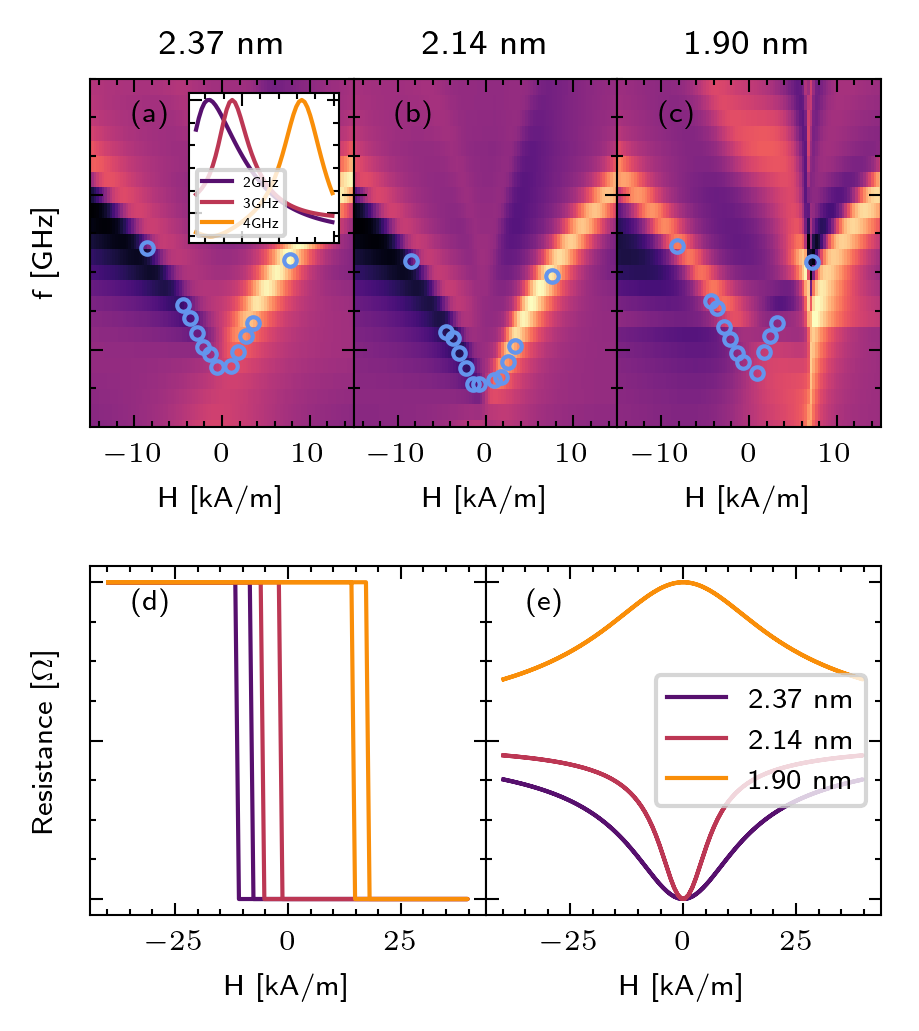

In [37]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as mtransforms
import matplotlib.cm as cm
import pandas as pd
from cmtj.utils import Filters

3
df = pd.read_csv('./data/dispersion_relation.csv', skiprows=[0], sep=',')

cmap = sns.color_palette('inferno', len(loops0))
freq_indx = (4, 8, 14)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

freq_indx = (4, 8, 14)
with plt.style.context(['science', 'nature']):

    fig = plt.figure(constrained_layout=True, figsize=(3.4, 8), dpi=300)
    gs = plt.GridSpec(4, 6)
    ax1 = fig.add_subplot(gs[0, :2])
    ax2 = fig.add_subplot(gs[0, 2:4], sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 4:], sharey=ax1)
    axs = [ax1, ax2, ax3]
    ax4 = fig.add_subplot(gs[1, :3])
    ax5 = fig.add_subplot(gs[1, 3:], sharey=ax4)

    for i, th in enumerate(loops0):
        ax4.plot(loop_Hrange / 1e3,
                 loops0[th],
                 label=f"{th} nm",
                 color=cmap[i])
        ax5.plot(loop_Hrange / 1e3,
                 loops90[th],
                 label=f"{th} nm",
                 color=cmap[i])

    ax4.set_xlabel("H [kA/m]")
    ax5.set_xlabel("H [kA/m]")
    ax4.set_ylabel(r"Resistance [$\Omega$]")
    ax5.legend(frameon=True, loc=5)

    for i, J in enumerate(Js):
        VSD2 = Filters.detrend_axis(VSD[i], 1)
        axs[i].pcolor(
            Hrange / 1e3,
            fscan / 1e9,
            VSD2,
            shading='auto',
            cmap=cm.get_cmap("magma"),
        )
        if labels[i] + "nm" in df.columns:
            axs[i].plot(df[labels[i] + "nmH"] * OetoAm / 1e3,
                        df[labels[i] + "nm"],
                        '.',
                        markeredgecolor='cornflowerblue',
                        markerfacecolor='none',
                        markersize=6,
                        mew=1)
        axs[i].set_title(labels[i] + " nm")
        axs[i].set_xlabel("H [kA/m]")
        axs[i].set_ylim([1, 5.5])
        axs[i].set_xlim([-15, 15])
        if i > 0:
            continue
        axins = inset_axes(axs[i], width=0.5, height=0.5, loc=1)
        for j, indx in enumerate(freq_indx):
            V = VSD2[indx, len(Hrange) // 2:]
            V = V / np.max(V)
            axins.plot(Hrange[:len(Hrange) // 2] / 1e3,
                       V,
                       label=f"{fscan[indx] / 1e9:.0f}GHz",
                       color=cmap[j])
        axins.tick_params(labelleft=False, labelbottom=False)
        axins.legend(loc=3, frameon=True, prop={'size': 3.5})

    axs[0].set_ylabel(r"f [GHz]")
    for label, ax in zip(('(a)', '(b)', '(c)', '(d)', '(e)'),
                         (ax1, ax2, ax3, ax4, ax5)):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                transform=ax.transAxes + trans,
                fontsize='medium',
                verticalalignment='top',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    fig.subplots_adjust(wspace=0, hspace=0.4)
    for ax in (ax2, ax2, ax5):
        ax.set_yticklabels([])


## PIMM

In [13]:
def simulate_pimm(J: float, stepsH: int = 100):
    int_step = 5e-13
    demag = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 1)]

    Ku = 0.8e3
    alpha = 0.024  # 0.024
    Ms1 = 1.03
    Ms2 = 1.65
    surf = 0.1
    l1 = Layer(
        "free",
        mag=CVector(1, 0.1, 0.1),
        anis=CVector(0, 1., 0.),  # direction of the anisotropy
        Ms=Ms1,
        thickness=2e-9,
        cellSurface=surf,
        demagTensor=demag,
        damping=alpha)

    l2 = Layer(
        "bottom",
        mag=CVector(1, 0.1, 0.1),
        anis=CVector(1, 0, 0),  # direction of the anisotropy
        Ms=Ms2,
        thickness=6e-9,
        cellSurface=surf,
        demagTensor=demag,
        damping=alpha)
    j1 = Junction([l1, l2], 100, 200)
    j1.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(Ku))
    j1.setLayerAnisotropyDriver("bottom", ScalarDriver.getConstantDriver(1e12))
    j1.setIECDriver("free", "bottom", ScalarDriver.getConstantDriver(J))
    spectrum = []
    Hscan, Hvecs = FieldScan.amplitude_scan(-800e3, 800e3, stepsH, 90, 45)
    div = 10
    j1.setLayerExternalFieldDriver(
        "all",
        AxialDriver(ScalarDriver.getConstantDriver(Hvecs[0][0]),
                    ScalarDriver.getConstantDriver(Hvecs[0][1]),
                    ScalarDriver.getConstantDriver(Hvecs[0][2])))
    j1.runSimulation(5e-9, int_step, int_step, solverMode=SolverMode.RK4)
    for hangle in Hvecs:
        j1.clearLog()
        j1.setLayerExternalFieldDriver(
            "all",
            AxialDriver(ScalarDriver.getConstantDriver(hangle[0]),
                        ScalarDriver.getConstantDriver(hangle[1]),
                        ScalarDriver.getConstantDriver(hangle[2])))
        HoeDriver = AxialDriver(
            NullDriver(), NullDriver(),
            ScalarDriver.getStepDriver(0, 500, 0.0, int_step * 5))
        j1.setLayerOerstedFieldDriver("all", HoeDriver)
        j1.runSimulation(15e-9, int_step, int_step, solverMode=SolverMode.RK4)
        log = j1.getLog()

        mixed = np.mean([
            np.asarray(log[f"{layer}_mz"]) * Ms
            for layer, Ms in zip(('free', 'bottom'), (Ms1, Ms2))
        ],
                        axis=0)
        mixed = np.squeeze(mixed)
        yf = np.abs(fft(mixed))
        frequencies = fftfreq(len(yf), int_step)
        frequencies = frequencies[:len(yf) // div]
        yf = yf[1:len(yf) // div]
        spectrum.append(yf)

    return np.asarray(spectrum), frequencies, Hscan


Jrange = np.linspace(1e-3, 0.5e-4, 30)
Jrange2 = -1 * Jrange
data = defaultdict(list)
data2 = defaultdict(list)
for J in tqdm(Jrange, desc="simulating J"):
    spectrum, frequencies, Hvecs = simulate_pimm(J)
    data['J'].append(J)
    data['spec'].append(spectrum)
    data['f'].append(frequencies)
    data['H'].append(Hvecs)

for J in tqdm(Jrange2, desc="simulating --J"):
    spectrum, frequencies, Hvecs = simulate_pimm(J)
    data2['J'].append(J)
    data2['spec'].append(spectrum)
    data2['f'].append(frequencies)
    data2['H'].append(Hvecs)

simulating J: 100%|██████████| 30/30 [02:44<00:00,  5.48s/it]


/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_58627/2494741559.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolor(Hvecs / 1e3,
/var/folders/wq/0q9brtfs5rq65q1t_mtgshb00000gn/T/ipykernel_58627/2494741559.py:45: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolor(Hvecs / 1e3,


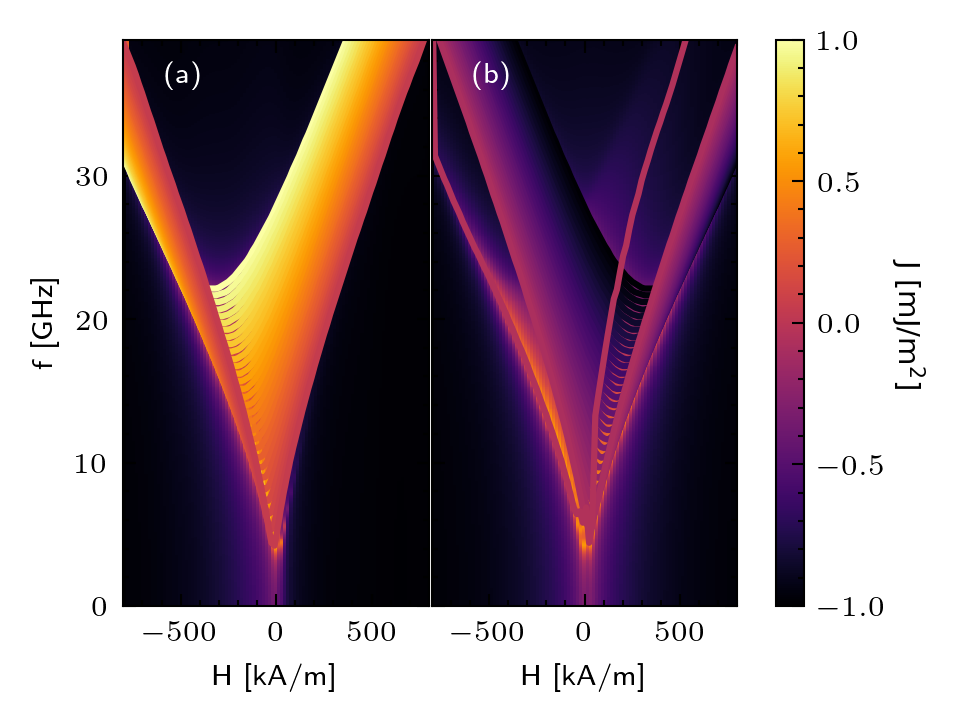

In [14]:
import seaborn as sns
import matplotlib.transforms as mtransforms
import matplotlib as mpl

with plt.style.context(['science', 'nature']):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, dpi=300)
    ax1.set_ylim([0, 39.5])
    ax2.set_ylim([0, 39.5])
    vmax = max(spectrum.max(), spectrum.min())
    # argmaxline
    lw = 1.5
    # palette = sns.color_palette("inferno", len(Jrange))
    spectrum1 = np.zeros_like(data['spec'][0])
    spectrum2 = np.zeros_like(data2['spec'][0])

    cmap = sns.color_palette("inferno", as_cmap=True)
    norm = mpl.colors.Normalize(vmin=min(Jrange.min(), Jrange2.min()) * 1e3,
                                vmax=max(Jrange.max(), Jrange2.max()) * 1e3)

    for i in range(Jrange.shape[0]):
        max_freqs = np.argmax(data['spec'][i], axis=1)
        ax1.plot(
            data['H'][0] / 1e3,
            data['f'][0][max_freqs] / 1e9,
            linewidth=lw,
            color=cmap(norm(Jrange[i] * 1e3)))

        max_freqs = np.argmax(data2['spec'][i], axis=1)
        ax2.plot(
            data2['H'][0] / 1e3,
            data2['f'][0][max_freqs] / 1e9,
            linewidth=lw,
            color=cmap(norm(Jrange2[i] * 1e3)))

        spectrum += data['spec'][i]
        spectrum2 += data2['spec'][i]
    ax1.pcolor(Hvecs / 1e3,
               frequencies / 1e9,
               spectrum.T,
               shading='auto',
               cmap='inferno')

    ax2.pcolor(Hvecs / 1e3,
               frequencies / 1e9,
               spectrum2.T,
               shading='auto',
               cmap='inferno')

    ax1.set_xlabel("H [kA/m]")
    ax2.set_xlabel("H [kA/m]")
    ax1.set_ylabel("f [GHz]")
    fig.subplots_adjust(wspace=0.01)

    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        ax=[ax1, ax2],
                        orientation='vertical')
    cbar.ax.set_ylabel(r"J [$\mathregular{mJ/m^2}$]",
                       rotation=270,
                       usetex=False)
    cbar.ax.get_yaxis().labelpad = 9.5
    for label, ax in zip(['(a)', '(b)'], (ax1, ax2)):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                color='w',
                transform=ax.transAxes + trans,
                fontsize='medium',
                verticalalignment='top',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))


# CIMS
In this section we focus on generating switching currents.

In [38]:
from cmtj.utils import calculate_resistance_series


def simulate_cims(H_ext: float, impulses: np.ndarray):
    w = 10e-6
    l = 75e-6

    Ms = 0.5
    Hk = 2508 * OetoAm
    K = Ms * Hk / 2
    jden = 6.94e10
    Hdl = 6.23e2 / jden * 1.35
    Hfl = 1.43e2 / jden * 1.35
    # surface is required for temperature calculation
    surf = w * l
    # approximate demagnetisation tensor
    demag = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 0)]
    ### Create MTJ ###
    # we use the .createSTTLayer to indicate the STT contributions
    # we can also create SOT layers for other experiments.
    alpha = 0.03
    l1 = Layer.createSOTLayer(
        "free",
        mag=CVector(0.1, 0.1, 1.),
        anis=CVector(0, 0., 1.),  # direction of the anisotropy
        Ms=Ms,
        thickness=1e-9,
        cellSurface=surf,
        demagTensor=demag,
        damping=alpha,
        dampingLikeTorque=Hdl,
        fieldLikeTorque=Hfl)

    j = Junction([l1])
    j.setLayerAnisotropyDriver("all", ScalarDriver.getConstantDriver(K))
    j.setLayerReferenceLayer("all", CVector(0, 1, 0))

    tstep = 1e-13

    hysteresis = []
    data = {}

    hangle = FieldScan.angle2vector(90, 0, H_ext)
    j.setLayerExternalFieldDriver(
        "free",
        AxialDriver(ScalarDriver.getConstantDriver(hangle.x),
                    ScalarDriver.getConstantDriver(hangle.y),
                    ScalarDriver.getConstantDriver(hangle.z)))
    for current in impulses:
        j.clearLog()
        j.setLayerMagnetisation("free", CVector(0, 0, -1))
        pulse = ScalarDriver.getTrapezoidDriver(0, current, 0, 1e-9, 3e-9)
        j.setLayerCurrentDriver("all", pulse)
        j.runSimulation(15e-9, tstep, tstep)

        log = j.getLog()
        str_ = "free"
        m = np.asarray(
            [[log[f'{str_}_mx'], log[f'{str_}_my'], log[f'{str_}_mz']]])
        Rx0 = [100]
        Ry0 = [1]
        SMR = [1.11]
        AMR = [0.41]
        AHE = [2.23]
        _, Rxy = calculate_resistance_series(Rx0,
                                             Ry0,
                                             AMR=AMR,
                                             AHE=AHE,
                                             SMR=SMR,
                                             m=m,
                                             number_of_layers=1,
                                             l=[l],
                                             w=[w])

        Rstable = Rxy[-100:].mean()
        hysteresis.append(Rstable)

    data['hysteresis'] = hysteresis
    critical_current = 0
    for i in range(1, len(hysteresis)):
        if abs(hysteresis[i] - hysteresis[i - 1]) > 0.1:
            critical_current = impulses[i]
    data['critical_current'] = critical_current
    return data


Hspace = np.linspace(-1200, 1200, 50, endpoint=True) * OetoAm
Imax = 1.4e13
impulses = np.linspace(-Imax, Imax, num=250)


def sim_warp(H_ext):
    return simulate_cims(H_ext, impulses)


critical_currents = np.zeros(len(Hspace))

for res in distribute(sim_warp, [Hspace]):
    indx, output = res
    critical_currents[indx] = output['critical_current']

100%|██████████| 50/50 [05:55<00:00,  7.12s/it]


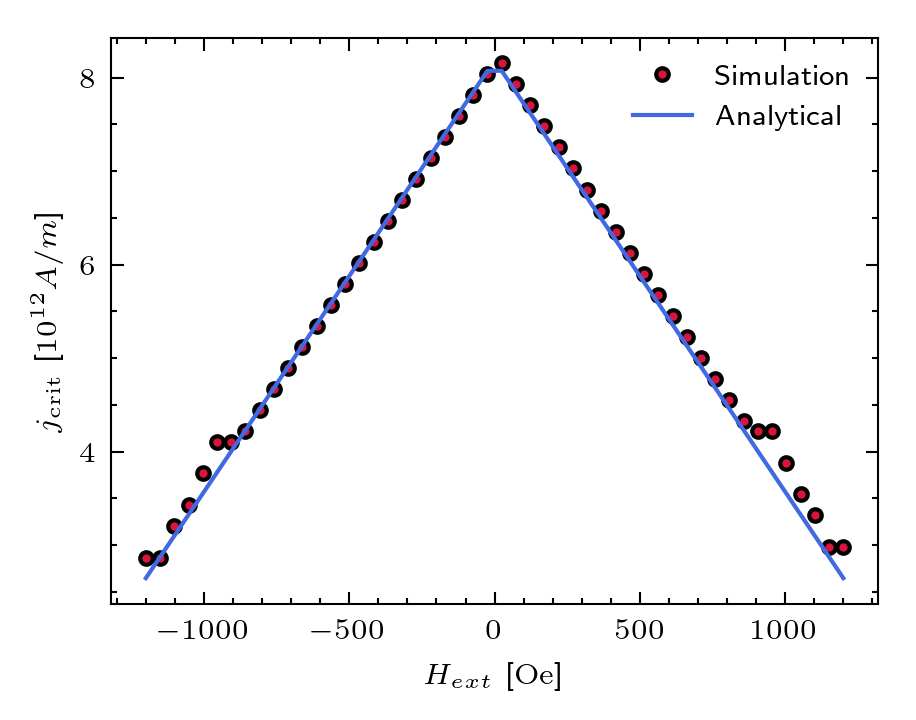

In [39]:
from cmtj.utils import hbar, echarge


def compute_j(Hx):
    Hk = 2508 * OetoAm
    Ms = 0.5
    thetaSH = 13.5
    tfm = 4e-9
    jc = (2 * echarge * Ms * tfm / hbar * thetaSH) * (Hk / 2 -
                                                      Hx / math.sqrt(2))
    return jc


cric_c = compute_j(Hx=np.abs(Hspace))

with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(dpi=300)
    ax.plot(Hspace / OetoAm,
            np.abs(critical_currents) / 1e12,
            'o',
            label='Simulation',
            color='crimson',
            markeredgecolor='k')
    ax.set_xlabel(r"$H_{ext}$ [$\mathrm{Oe}$]")
    ax.set_ylabel(r"$j_\mathrm{crit}$ [$\mathdefault{10^{12} A/m}$]")
    ax.plot(Hspace / OetoAm,
            cric_c / 1e12,
            label='Analytical',
            color='royalblue')
    ax.legend()

# Stack system
In this section we will simulate a simple parallel structure of two MTJs.

In [59]:
from tqdm import tqdm
from scipy.fft import fft, fftfreq
from cmtj.utils import FieldScan
import seaborn as sns
from scipy.ndimage import uniform_filter
from cmtj.stack import ParallelStack, SeriesStack

damping = 0.005
Ms = 1.6
thickness = 1.8e-9
SLP = 0.69
beta = 1
spin_polarisation = 1.
surf = 70e-9 * 70e-9 * np.pi
demag = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 1)]
### Create MTJ ###
# we use the .createSTTLayer to indicate the STT contributions
# we can also create SOT layers for other experiments.
l1 = Layer.createSTTLayer("free",
                          mag=CVector(0, 0, .9),
                          anis=CVector(0, 0, 1),
                          Ms=Ms,
                          thickness=thickness,
                          cellSurface=surf,
                          demagTensor=demag,
                          damping=damping,
                          SlonczewskiSpacerLayerParameter=SLP,
                          beta=beta,
                          spinPolarisation=spin_polarisation)
l2 = Layer.createSTTLayer("free",
                          mag=CVector(0, 0, 1),
                          anis=CVector(0., 0., 1),
                          Ms=Ms * 1.11,
                          thickness=thickness,
                          cellSurface=surf,
                          demagTensor=demag,
                          damping=damping,
                          SlonczewskiSpacerLayerParameter=SLP,
                          beta=beta,
                          spinPolarisation=spin_polarisation)

# we use pinning layers for the bottom layer
l1.setReferenceLayer(CVector(1, 0, 0))
l2.setReferenceLayer(CVector(1, 0, 0))

j1 = Junction([l1], 100, 200)
j2 = Junction([l2], 110, 220)

j1.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(7e4))
j2.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(10e4))
stack = ParallelStack([j1, j2])

int_time = 1e-12
sim_time = 100e-9
stack.setCoupledCurrentDriver(ScalarDriver.getConstantDriver(6e10))

k = 20
Hspan, Hrange = FieldScan.amplitude_scan(0, 400e3, 100, 5, 0)
couplings = defaultdict(list)
for label, coupling in zip(('pos', 'zero', 'neg'), (0.15, 0, -0.15)):
    stack.setCouplingStrength(coupling)
    spectrum = []
    for Hvector in tqdm(Hrange):
        stack.clearLogs()
        stack.setExternalFieldDriver(
            AxialDriver(ScalarDriver.getConstantDriver(Hvector[0]),
                        ScalarDriver.getConstantDriver(Hvector[1]),
                        ScalarDriver.getConstantDriver(Hvector[2])))
        stack.runSimulation(sim_time, int_time, int_time)

        log = stack.getLog()
        y = fft(log['Resistance'])
        yk = np.abs(y[:len(y) // k])
        spectrum.append(yk)
    spectrum = np.asarray(spectrum)
    spectrum = uniform_filter(spectrum, size=7)
    freqs = fftfreq(len(y), d=int_time)
    freqs = freqs[:len(freqs) // k]
    couplings[f'{label}_freqs'] = freqs
    couplings[f'{label}_spectrum'] = spectrum

100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


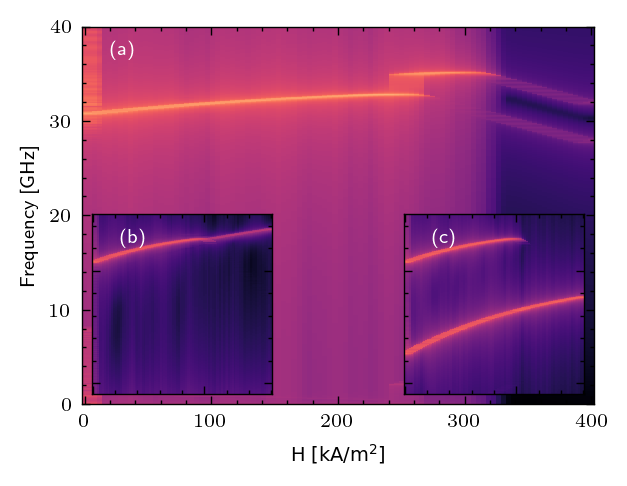

In [60]:
cmap = sns.color_palette("magma", as_cmap=True)
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(dpi=200)
    ax.set_ylim([0, 40])
    ax.pcolor(Hspan / 1e3,
              freqs / 1e9,
              np.log10(couplings['neg_spectrum'].T),
              cmap=cmap,
              shading='auto')
    ax.set_xlabel("H [$\mathrm{kA/m^2}$]", usetex=False)
    ax.set_ylabel("Frequency [GHz]")

    axins = inset_axes(ax, width=0.9, height=0.9, loc=3)
    axins.pcolor(Hspan / 1e3,
                 freqs / 1e9,
                 np.log10(couplings['pos_spectrum'].T),
                 cmap=cmap,
                 shading='nearest')
    axins.set_ylim([19, 35])
    axins.tick_params(labelleft=False, labelbottom=False)

    axins2 = inset_axes(ax, width=0.9, height=0.9, loc=4)
    axins2.pcolor(Hspan / 1e3,
                  freqs / 1e9,
                  np.log10(couplings['zero_spectrum'].T),
                  cmap=cmap,
                  shading='nearest')
    axins2.set_ylim([19, 35])
    axins2.tick_params(labelleft=False, labelbottom=False)
    for label, ax in zip(['(a)', '(b)', '(c)'], (ax, axins, axins2)):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                color='w',
                transform=ax.transAxes + trans,
                fontsize='medium',
                verticalalignment='top',
                bbox=dict(facecolor='none', edgecolor='none', pad=3.0))